# Distribution fitting with pytorch 

## Overview 
This is a POC of using pytorch to do distribution fitting. This might be useful because it might give us more control over things like parameter initialization, learning rate, and optimization configuration. Also, it makes it easy to track how estimates change during the optimization process. This can help us identify cases where we're getting stuck in local minima. 

- Use the likelihood function of weibull 2p as the loss function 
- The "model" is really just the shape and scale params. During training, we run N iterations. In each iteration, we use the current estimated params to evaluate the loss, calculate gradient, and take an optimization step. 
- After some experimentation, the following config seems to work well: 
  - Initialize weights/params with `weights = torch.distributions.Uniform(0, 4).sample((2,))`
  - Use optimizer `torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)`
  - Use n=2000 iterations in training loop (similar to epochs in more standard ML problems)


Other things to try: 
- Direct comparison with scipy and reliability fits
- For both LBFGS and Adam, how to deal with the case where param estimate becomes negative? When that happens at a certain optimization step, the loss for that step in nan, and then all further steps fail.
- Check why Adam can't deal estimate large scale values (larger than 1.0). Confirm that LBFGS can. 
- Confirm that it makes sense that the loss function can become negative. In most of the good fits I see, this is the case. 
- Set up tracking of validation loss + early stopping
- Fit mixtures of Weibulls instead of single weibulls. See function `weibull_mixture_nll` below. We would also have to change the `Model` class to have six weights: `p1, p2, shape1, shape2, scale1, scale2`. However, keep in mind that the goal is not perfect fit. Focus on interpretability and business purpose over perfect fit. 





## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data setup 

In [2]:
np.random.seed(2023)

n = 100
shape = 4
scale = 10

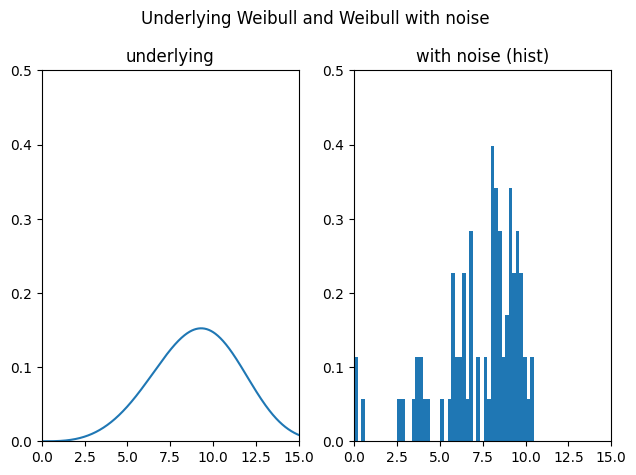

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, 0.1, n)  
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

truncate = True 
trunc_limit = scale + .5
if truncate: 
    weibull_data = weibull_data[weibull_data < trunc_limit]
    
add_infant_mortality = True 
im_shape = .5
im_scale = scale/2
im_num_points = int(n/10)
if add_infant_mortality: 
    weibull_data = np.concatenate([weibull_data, weibull_min.rvs(c=im_shape, scale=im_scale, size=im_num_points)])

#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 25, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=50, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 15)
    ax[idx].set_ylim(0, .5)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

# set up tensor for pytorch ops 
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

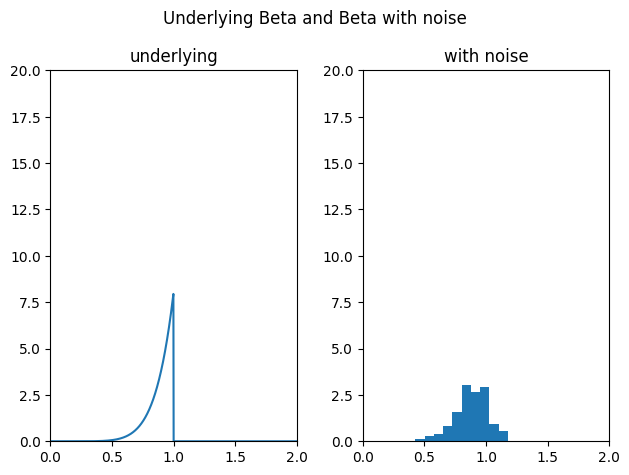

In [4]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 2, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 2.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

****
# Utility functions 

In [5]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

****
# Model setup 

In [6]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 4).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [7]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    print('scale, shape, loss \n')
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss) 
        if i % 100 == 0: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        
    return losses

In [8]:
def weibull_nll(data, lambda_, k): 
    log_likelihood = torch.sum(torch.log(k / lambda_) + (k - 1) * torch.log(data / lambda_) - (data / lambda_) ** k)
    nll = -log_likelihood
    return nll

In [9]:
def weibull_mixture_nll(data, alphas, betas, pis):
    # todo: verify that this is correct 
    data = data.unsqueeze(1).expand_as(alphas)
    likelihood = pis * torch.exp((torch.log(data) - torch.log(alphas)) * betas - (data / alphas) ** betas)
    log_likelihood = torch.log(likelihood.sum(dim=1)).sum()
    nll = -log_likelihood
    return nll

****
# Using Adam optimizer on Weibull data 

scale, shape, loss 

iter 0: 3.9605414867401123, 2.3381717205047607, 409.44416290228787
iter 100: 4.660083293914795, 1.6641792058944702, 261.40947302234747
iter 200: 5.022709846496582, 1.4996511936187744, 248.10407444944525
iter 300: 5.329307556152344, 1.5374000072479248, 242.07399982680528
iter 400: 5.6345109939575195, 1.6444071531295776, 236.26915617812512
iter 500: 5.941617488861084, 1.7765328884124756, 230.62425034759966
iter 600: 6.241853713989258, 1.918999195098877, 225.43962098084756
iter 700: 6.525271892547607, 2.0639500617980957, 220.948386934834
iter 800: 6.783799171447754, 2.205272912979126, 217.2747385264919
iter 900: 7.012174129486084, 2.3380050659179688, 214.43111526995742
iter 1000: 7.208098888397217, 2.4585673809051514, 212.34016659396386
iter 1100: 7.371857643127441, 2.564908742904663, 210.87214885681345
iter 1200: 7.505648612976074, 2.6563851833343506, 209.8821855043317
iter 1300: 7.612833499908447, 2.7334413528442383, 209.23709589696057
iter 1400: 7.697286605834961, 

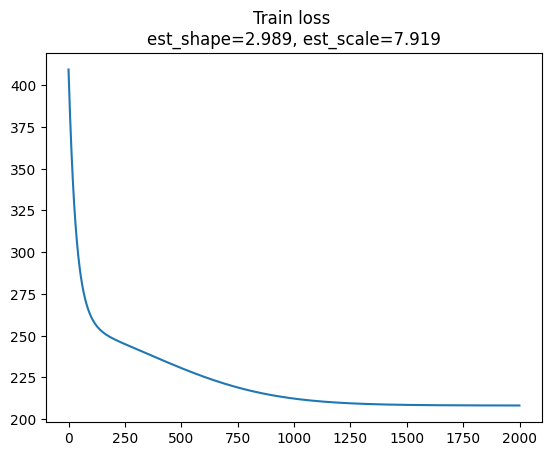

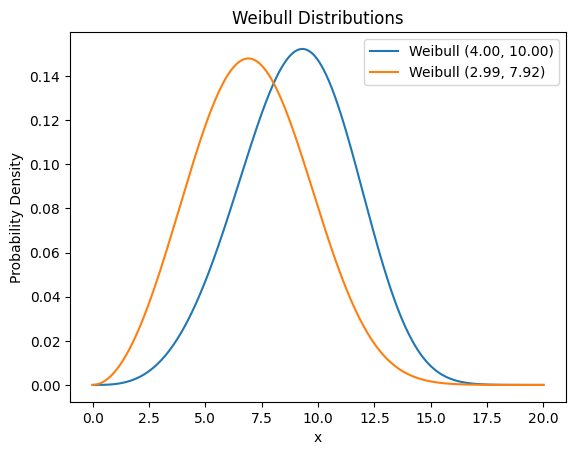

Actual shape=4


In [10]:
m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=weibull_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

# Using Adam optimizer on Beta data 

scale, shape, loss 

iter 0: 1.3446307182312012, 0.8349313735961914, 112.08211599404041
iter 100: 0.8886333107948303, 1.7172023057937622, 36.329527493110206
iter 200: 0.8976076245307922, 2.38895845413208, 6.28060578040544
iter 300: 0.9028823971748352, 2.9589884281158447, -11.853632654636364
iter 400: 0.9073557257652283, 3.461638927459717, -24.163462288125448
iter 500: 0.9111962914466858, 3.9071850776672363, -32.90957347578437
iter 600: 0.9145176410675049, 4.302538871765137, -39.29117612392503
iter 700: 0.917407214641571, 4.653894424438477, -44.037643175109054
iter 800: 0.919933557510376, 4.966594219207764, -47.618369499709964
iter 900: 0.9221509099006653, 5.245203018188477, -50.34861673433576
iter 1000: 0.9241029620170593, 5.493663311004639, -52.44767848623932
iter 1100: 0.9258256554603577, 5.715396881103516, -54.07200050479123
iter 1200: 0.927349328994751, 5.913382053375244, -55.335475084770984
iter 1300: 0.9286990165710449, 6.090242385864258, -56.32241773495595
iter 1400: 0.929896295

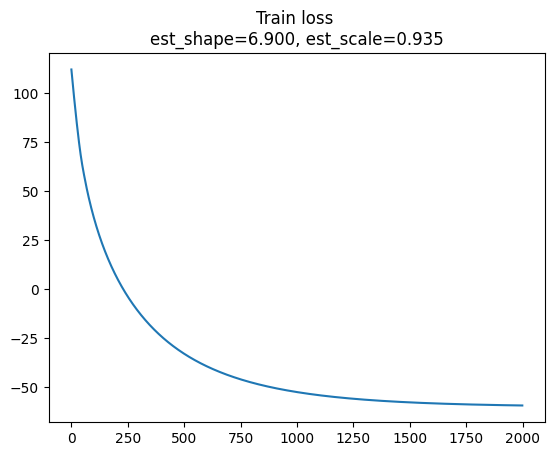

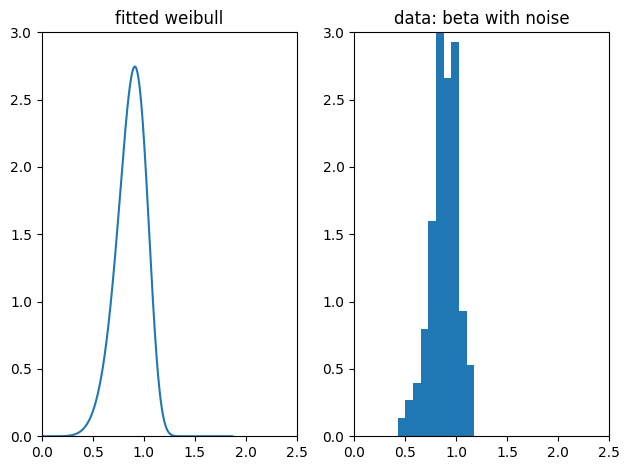

In [11]:
beta_tensor = torch.tensor(beta_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=beta_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
# print(f'\nActual params: shape={shape}, scale={scale}')
# print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
# print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()


txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()


****
# Using LBFGS optimizer on Weibull data 

scale, shape, loss 

iter 0: 1.28118896484375, 1.4605579376220703, 1048.7870637596543
iter 0: 1.3198322057724, 1.3992011547088623, 903.4625159322568
iter 0: 1.3338208198547363, 1.370046615600586, 847.8130795457445
iter 0: 1.345881462097168, 1.33625328540802, 792.2608696013374
iter 0: 1.3549058437347412, 1.2998967170715332, 740.7003522523636
iter 0: 1.3608118295669556, 1.2610019445419312, 692.9048107417392
iter 0: 1.363531231880188, 1.219778060913086, 648.8423124737831
iter 0: 1.363063931465149, 1.1765109300613403, 608.4758538763128
iter 0: 1.3594911098480225, 1.131576657295227, 571.7667686929101
iter 0: 1.3529871702194214, 1.0854421854019165, 538.6664559430709
iter 0: 1.343826413154602, 1.0386571884155273, 509.10678987031304
iter 0: 1.332382082939148, 0.9918354749679565, 482.9901974280686
iter 0: 1.3191142082214355, 0.9456250071525574, 460.1812273478804
iter 0: 1.30454683303833, 0.9006679058074951, 440.5007709712394
iter 0: 1.2892358303070068, 0.8575578331947327, 423.72634317946927
ite

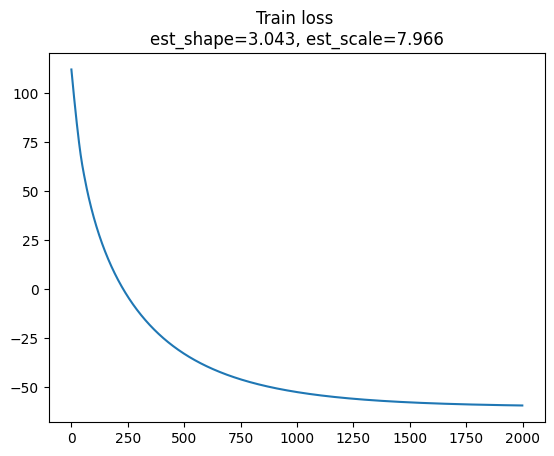

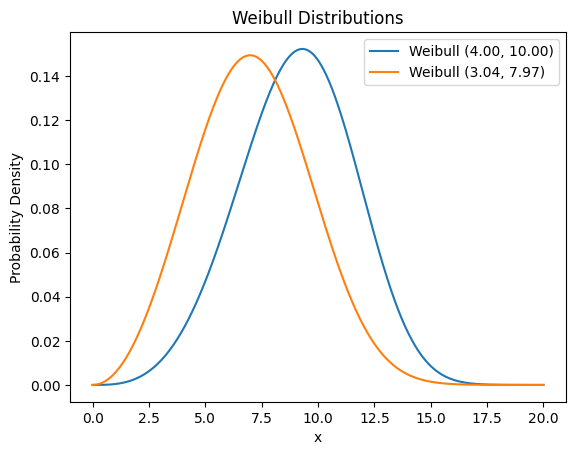

Actual shape=4


In [12]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(weibull_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(weibull_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

****
# Using LBFGS optimizer on Beta data 

scale, shape, loss 

iter 0: 3.660184860229492, 0.8340344429016113, 154.61998615286262
iter 0: 3.6155409812927246, 0.8893906474113464, 153.0544124377315
iter 0: 3.5805108547210693, 0.9102034568786621, 152.24160556566267
iter 0: 3.421494483947754, 0.9833676815032959, 148.82593347048174
iter 0: 1.5470021963119507, 1.7886682748794556, 67.98656703527695
iter 0: -5.506036758422852, 4.819870471954346, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
i

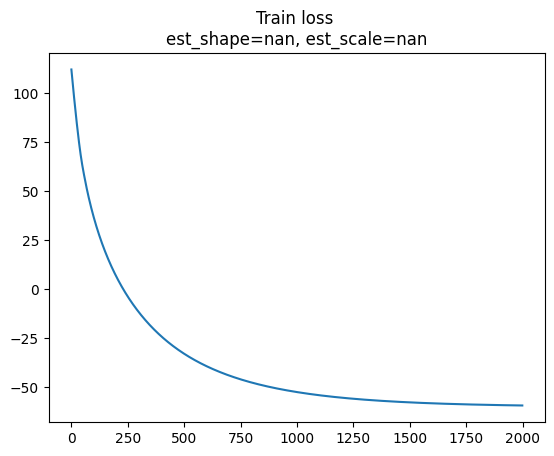

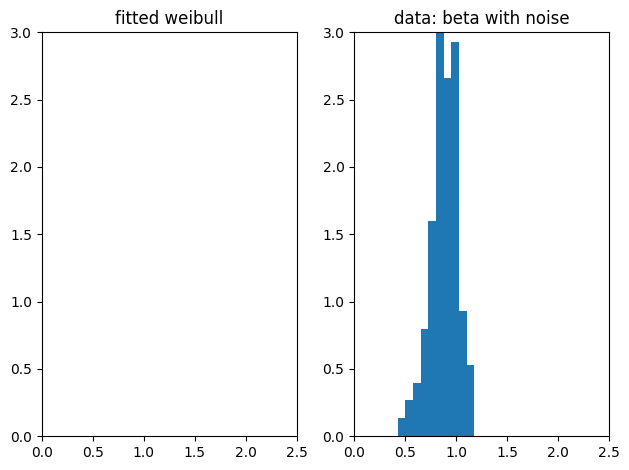

In [13]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(beta_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(beta_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}' 
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()

****
# Random stuff 

/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


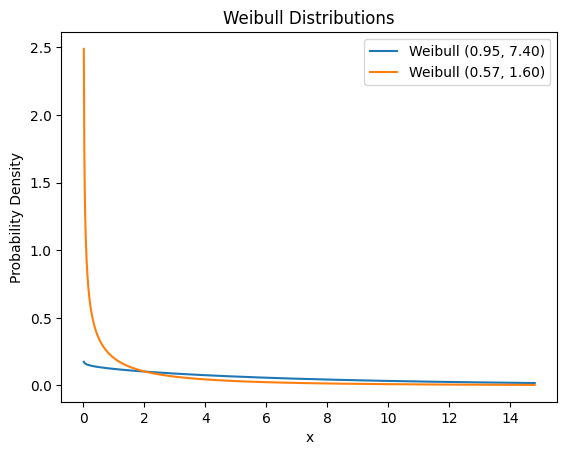

In [14]:
plot_weibull_distributions((.95, 7.4), (.57, 1.6))